# Tutorial for Simple Route Optimization with ASKCOS 
Assumes ASKCOS exists in directory and can be imported. 
Follow installation instructions in README

### Define Targets and Scores
These are Compounds 2-6 from Figure 2 in [1]. Scores are arbitrary.  

[1] Kettle JG, Wilson DM. Drug Discov Today. 2016;21(10):1596-1608. doi:10.1016/j.drudis.2016.06.007

In [1]:
target_dict = {
    "COC5=CC(N=CN=C6NC7=CC=CC(OC)=C7)=C6C=C5OC" : 3,
    "COC1=CC(N=CN=C2NC3=CC=C(OCC4=CC=CC=C4)C=C3)=C2C=C1OC" : 4,
    "COC8=CC(N=CN=C9NC%10=CC=CC(Cl)=C%10)=C9C=C8OC" : 2,
    "COC%11=CC(N=CN=C%12NC%13=CC=CC(O)=C%13)=C%12C=C%11OC" : 11,
    "COC%14=CC(N=CN=C%15NC%16=CC=C(NC(C%17=CC=CC=C%17)=O)C=C%16)=C%15C=C%14OC" : 14,
}

### Build Tree 

In [ ]:
import sys, os 
sys.path.append('/home/jfromer/sparrow/askcos-core') # change this for your system to where askcos folder is located
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # use askcos on CPUs only 

from sparrow.tree_build_utils import build_rxn_graph
build_rxn_graph(
    target_smis=list(target_dict.keys()),
    n_cpus=10,
    time_per_target=15, 
    filename='tutorial_paths.json'
)
# This will end with a broken pipe error but route_graph should still be defined. You can continue and ignore it 

Turn the saved json into a route graph 

In [2]:
from sparrow.route_graph import RouteGraph

route_graph = RouteGraph()
route_graph.add_from_json('tutorial_paths.json')

TypeError: tuple expected at most 1 arguments, got 2

## Define reaction scorer and condition recommender

In [7]:
from sparrow.condition_recommender import AskcosRecommender
from sparrow.scorer import AskcosScorer

recommender = AskcosRecommender()
scorer = AskcosScorer()

TypeError: Can't instantiate abstract class AskcosScorer with abstract methods requires_contexts

### Set up the problem and solve 
First, define RouteSelector object and calculate reaction scores. Only reason to _not_ calculate scores is if you are loading a previously saved route_graph which has reaction scores already. (Reaction scores indicate how confident the ASCKOS forward predictor module is in desired product actually being produced)
Second, define optimization problem variables, set the objectives and constraints, and finally solve

In [5]:
from sparrow.route_selector import RouteSelector

route_selector = RouteSelector(
    route_graph,
    target_dict,
    condition_recommender=recommender,
    rxn_scorer=scorer,
    weights=[1,1,1,1]
) # conditions and scoring will happen during initialization with the current setup 

route_selector.define_variables()
route_selector.set_objective()
route_selector.set_constraints()
route_selector.optimize(solver=None) # solver='GUROBI' for GUROBI (license needed)



NameError: name 'recommender' is not defined

### Visualize the results 

Selected targets: 
COc1cc2ncnc(Nc3cccc(O)c3)c2cc1OC
COc1cccc(Nc2ncnc3cc(OC)c(OC)cc23)c1
COc1cc2ncnc(Nc3ccc(NC(=O)c4ccccc4)cc3)c2cc1OC


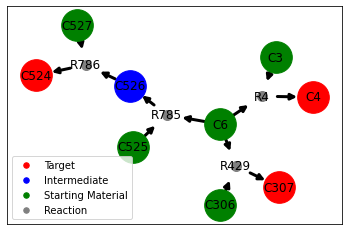

In [6]:
from sparrow.visualizer import Visualizer
import matplotlib.pyplot as plt

vis = Visualizer(
    route_graph,
    nonzero_vars=route_selector.optimal_variables(),
    )

fig_out_dir = "optimal_routes.png"
vis.plot_graph(fig_out_dir)

plt.show()